In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import scipy
import statsmodels

import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline
np.random.seed(0)

## Data

In [2]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [4]:
pandas_profiling.ProfileReport(df)

Number of variables,25
Number of observations,30000
Total Missing (%),0.0%
Total size in memory,5.7 MiB
Average record size in memory,200.0 B
Numeric,18
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,5


## Code

In [5]:
def get_bootstrap_samples(data, n_samples):
    for i in range(n_samples):
        indices = np.random.randint(0, len(data), len(data))
        samples = data[indices]
        yield samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

## LIMIT_BAL

In [6]:
print("median limit for paid loans", df[df['default'] == 0]['LIMIT_BAL'].median())
print("median limit for not paid loans", df[df['default'] == 1]['LIMIT_BAL'].median())

median limit for paid loans 150000.0
median limit for not paid loans 90000.0


In [7]:
limit_paid_median = np.fromiter((np.median(s) for s in get_bootstrap_samples(df[df['default'] == 0]['LIMIT_BAL'].values, 1000)), float)
limit_notpaid_median = np.fromiter((np.median(s) for s in get_bootstrap_samples(df[df['default'] == 1]['LIMIT_BAL'].values, 1000)), float)

print("95% confidence interval for the paid loans median limit:",  stat_intervals(limit_paid_median, 0.05))
print("95% confidence interval for the not paid loans median limit:",  stat_intervals(limit_notpaid_median, 0.05))
print("95% confidence interval for the delta:",  stat_intervals(limit_paid_median - limit_notpaid_median, 0.05))

95% confidence interval for the paid loans median limit: [ 150000.  150000.]
95% confidence interval for the not paid loans median limit: [ 80000.  90000.]
95% confidence interval for the delta: [ 60000.  70000.]


In [8]:
limit_paid = df[df['default'] == 0]['LIMIT_BAL'].values
limit_notpaid = df[df['default'] == 1]['LIMIT_BAL'].values
stats.mannwhitneyu(limit_paid, limit_notpaid)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)

## SEX

In [9]:
print("paid:")
print(df[df['default'] == 0]['SEX'].value_counts())
print("notpaid:")
print(df[df['default'] == 1]['SEX'].value_counts())

paid:
2    14349
1     9015
Name: SEX, dtype: int64
notpaid:
2    3763
1    2873
Name: SEX, dtype: int64


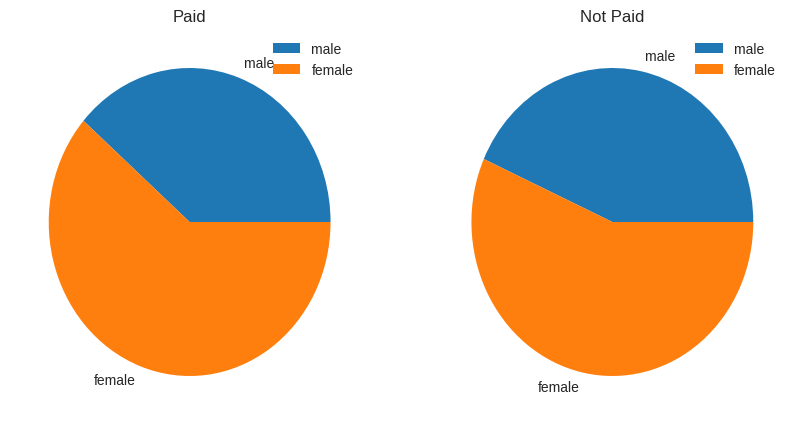

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.pie(df[df['default'] == 0].groupby('SEX').size(), labels=['male', 'female'])
plt.title('Paid')
plt.legend()

plt.subplot(1,2,2)
plt.pie(df[df['default'] == 1].groupby('SEX').size(), labels=['male', 'female'])
plt.title('Not Paid')
plt.legend()

plt.show()

In [11]:
sum(df[df['default'] == 0]['SEX'])

37713

In [12]:
print("Normal:")
print(statsmodels.stats.proportion.proportion_confint(
    df[(df['default'] == 0) & (df['SEX'] == 1)]['SEX'].count(),
    df[df['default'] == 0].shape[0],
    method = 'normal'))
print(statsmodels.stats.proportion.proportion_confint(
    df[(df['default'] == 1) & (df['SEX'] == 1)]['SEX'].count(),
    df[df['default'] == 1].shape[0],
    method = 'normal'))

print("Wilson:")
print(statsmodels.stats.proportion.proportion_confint(
    df[(df['default'] == 0) & (df['SEX'] == 1)]['SEX'].count(),
    df[df['default'] == 0].shape[0],
    method = 'wilson'))
print(statsmodels.stats.proportion.proportion_confint(
    df[(df['default'] == 1) & (df['SEX'] == 1)]['SEX'].count(),
    df[df['default'] == 1].shape[0],
    method = 'wilson'))

Normal:


AttributeError: module 'statsmodels' has no attribute 'stats'

In [ ]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [ ]:
df['SEX_BI'] = df['SEX'] - 1
print("confidence interval for delta:", proportions_confint_diff_ind(df[df['default'] == 0]['SEX_BI'], df[df['default'] == 1]['SEX_BI']))

## EDUCATION

In [ ]:
df.loc[df['EDUCATION'] == 0, 'EDUCATION_S'] = 'Doctor'
df.loc[df['EDUCATION'] == 1, 'EDUCATION_S'] = 'Master'
df.loc[df['EDUCATION'] == 2, 'EDUCATION_S'] = 'Bachelor'
df.loc[df['EDUCATION'] == 3, 'EDUCATION_S'] = 'High School'
df.loc[df['EDUCATION'] == 4, 'EDUCATION_S'] = 'Elementary'
df.loc[df['EDUCATION'] == 5, 'EDUCATION_S'] = 'Other'
df.loc[df['EDUCATION'] == 6, 'EDUCATION_S'] = 'No data'

df['EDUCATION_S'].value_counts()

In [ ]:
df_contingency = pd.crosstab(df['EDUCATION_S'], df['default'])
df_contingency

In [ ]:
df_contingency.div(df_contingency.sum(1), axis=0).fillna(0).plot(kind='bar')

In [ ]:
print(stats.f_oneway(
    df[df['EDUCATION_S'] == 'Bachelor']['default'],
    df[df['EDUCATION_S'] == 'Doctor']['default'],
    df[df['EDUCATION_S'] == 'Elementary']['default'],
    df[df['EDUCATION_S'] == 'High School']['default'],
    df[df['EDUCATION_S'] == 'Master']['default'],
    df[df['EDUCATION_S'] == 'No data']['default'],
    df[df['EDUCATION_S'] == 'Other']['default']))

print(stats.kruskal(
    df[df['EDUCATION_S'] == 'Bachelor']['default'],
    df[df['EDUCATION_S'] == 'Doctor']['default'],
    df[df['EDUCATION_S'] == 'Elementary']['default'],
    df[df['EDUCATION_S'] == 'High School']['default'],
    df[df['EDUCATION_S'] == 'Master']['default'],
    df[df['EDUCATION_S'] == 'No data']['default'],
    df[df['EDUCATION_S'] == 'Other']['default']))

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('default ~ EDUCATION_S', data=df).fit()
print(sm.stats.anova_lm(mod, typ=2))